# Transfer Learning on pretrained VGGish model for emotion classification

This notebook shows how we can use a pretrained model that was previously used to create embeddings for Youtube audio ([VGGish](https://github.com/tensorflow/models/tree/master/research/audioset)) to train a classifier to recognise emotions in a much smaller dataset ([RAVDESS](https://smartlaboratory.org/ravdess/)).

## Setup

Before getting started we should make sure that we have a suitable GPU for the task that is CUDA compatible so that we can run tensorflow. I trained this model on a relatively recent (at time of writing this) Dell Windows laptop with an i7-7700HQ, a GTX 1060-MaxQ, and 16GB of RAM. Running the whole notebook takes under 30 minutes for me (a decent chunk of which is loading and preprocessing the data).

With these requirements met we can start setting the project up. First we will need to fetch a few files and load up the environment:

1. Download the pretrained VGG model from [here](https://storage.googleapis.com/audioset/vggish_model.ckpt)
1. Move the VGG model into `./pretrained_models/`
1. Download the RAVDESS speech dataset from [here](https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1)
1. Extract the zip into `./data`
1. Install [conda](https://conda.io/)
1. Install dependencies: `conda env create -f environment.yml`
1. Activate environment: `source activate vggec`
1. Run jupyter: `jupyter notebook`
1. Open the notebook in your browser.
1. Hit run!

## Load labels

First we need to load our label data and get it into a shape we can work with. The labels are given in the `.wav` file names, so we'll have to load the names for processing:

In [1]:
from pathlib import Path

data_path = Path("../data")
data_path

WindowsPath('../data')

### List all WAV files

In [2]:
wav_files = data_path.glob("*.wav")
wav_files = list(wav_files)
wav_files[:5]

[WindowsPath('../data/03-01-01-01-01-01-01.wav'),
 WindowsPath('../data/03-01-01-01-01-01-02.wav'),
 WindowsPath('../data/03-01-01-01-01-01-03.wav'),
 WindowsPath('../data/03-01-01-01-01-01-04.wav'),
 WindowsPath('../data/03-01-01-01-01-01-05.wav')]

### Map file names to their classes.

Each emotion is labelled as 01 - 08, so we convert that to labels 0 - 7. However, we will later find out that the model has difficulty keeping some similar emotions apart, so we combine a few and end up with labels 0 - 4.

We also need the speaker information so that we can later split the data into train/val/test based on speaker, to evaluate how well the model performs when it encouters unknown speakers (something it would obviously have to deal with in the real world). 

In [3]:
def class_from_file_name(fname):
    # neutral + calm
    # sad + fearful
    # happy
    # angry + disgust
    # surprised
    original_class = int(fname.split('-')[2]) - 1
    if original_class in [0, 1]:
        return 0
    if original_class in [3, 5]:
        return 1
    if original_class in [2]:
        return 2
    if original_class in [4, 6]:
        return 3
    return 4

def speaker_from_file_name(fname):
    return int(fname.split('-')[6].split('.')[0]) - 1

labels = {
    f.name: {
        "class": class_from_file_name(f.name),
        "speaker": speaker_from_file_name(f.name)
    }
    for f in wav_files
}
[(k, v) for k, v in labels.items()][:5]

[('03-01-01-01-01-01-01.wav', {'class': 0, 'speaker': 0}),
 ('03-01-01-01-01-01-02.wav', {'class': 0, 'speaker': 1}),
 ('03-01-01-01-01-01-03.wav', {'class': 0, 'speaker': 2}),
 ('03-01-01-01-01-01-04.wav', {'class': 0, 'speaker': 3}),
 ('03-01-01-01-01-01-05.wav', {'class': 0, 'speaker': 4})]

### Extract number of classes

In [4]:
CLASSES = list(set([v["class"] for v in labels.values()]))
NUM_CLASSES = len(CLASSES)
NUM_CLASSES

5

## Load Data

### Fix PYTHONPATH

The original VGGish repository includes some files for loading the original trained model as well as preprocessing the audio data into the input shape the model expects. I have copied those files for convenience. We just need to add the path to them to the pythonpath so that we can import the modules:

In [5]:
import os
import sys
nb_dir = Path(os.getcwd())
vgg_dir = nb_dir.parent / 'vgg'
vgg_dir

WindowsPath('D:/Work/playground/vgg-emotion-classifier/vgg')

In [6]:
if str(vgg_dir) not in sys.path:
    sys.path.append(str(vgg_dir))
sys.path

['',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec\\python36.zip',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec\\DLLs',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec\\lib',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec\\lib\\site-packages',
 'C:\\Users\\Sam\\Anaconda3\\envs\\vggec\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Sam\\.ipython',
 'D:\\Work\\playground\\vgg-emotion-classifier\\vgg']

### Read WAV files

Read in the wav files and convert them into the correct shape for the VGGish model (this is thankfully taken care of already by the example code provided)

In [7]:
from vggish_input import wavfile_to_examples 

In [8]:
data = {
    f.name: wavfile_to_examples(str(f))
    for f in wav_files
}

In [79]:
data['03-01-01-01-01-01-01.wav'].shape

(3, 96, 64)

### Split dataset

As previously mentioned, we need to split the different sets by speaker - especially since there are multiple files per speaker saying the same thing with slightly different intonation, which would result in some overlap between the sets otherwise!

Split into

* train: 80%
* val: 10%
* test: 10%

(This split works a bit better to create even splits since we only have 24 speakers.)

In [9]:
from random import shuffle

speakers = list(set([v["speaker"] for k, v in labels.items()]))

seed = 987234871
shuffle(speakers)

train_speakers_index = int(0.8 * len(speakers))
val_speakers_index = int(0.9 * len(speakers))
train_speakers = speakers[:train_speakers_index]
val_speakers = speakers[train_speakers_index:val_speakers_index]
test_speakers = speakers[val_speakers_index:]

print(f"Training speakers: {train_speakers}")
print(f"Validation speakers: {val_speakers}")
print(f"Test speakers: {test_speakers}")

Training speakers: [15, 21, 23, 9, 19, 22, 16, 7, 0, 20, 8, 17, 6, 18, 1, 13, 14, 2, 3]
Validation speakers: [5, 12]
Test speakers: [4, 11, 10]


Now that we have split the speakers into groups, we can can split the actual data by speaker:

In [10]:
import numpy as np

x_train, y_train = zip(*[(data[key], value["class"]) for key, value in labels.items() if value["speaker"] in train_speakers])
x_val, y_val = zip(*[(data[key], value["class"]) for key, value in labels.items() if value["speaker"] in val_speakers])
x_test, y_test = zip(*[(data[key], value["class"]) for key, value in labels.items() if value["speaker"] in test_speakers])

x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(f"Training size: {len(x_train)}")
print(f"Validation size: {len(x_val)}")
print(f"Test size: {len(x_test)}")


Training size: 1140
Validation size: 120
Test size: 180


### Convert labels to one-hot vectors

For multi-class classification using categorical crossentropy we want the labels in one-hot encoded form.

E.g. label `1` becomes `[0, 1, 0, 0 ,0 ,0, 0, 0]`

In [11]:
import numpy as np

def to_one_hot(y, num_classes):
    y_one_hot = np.zeros(((y.size, num_classes)))
    y_one_hot[np.arange(y.size), y] = 1
    return y_one_hot

In [12]:
y_train = to_one_hot(y_train, NUM_CLASSES)
y_val = to_one_hot(y_val, NUM_CLASSES)
y_test = to_one_hot(y_test, NUM_CLASSES)
y_train[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

### Compute balanced weights

The number of instances for each class isn't balanced, so we need to create weightings for each class to even things out during training

In [13]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  CLASSES,
                                                  list([v["class"] for v in labels.values()]))
class_weights

array([1.  , 0.75, 1.5 , 0.75, 1.5 ])

### Create function to get batches from data

In [14]:
from random import shuffle
def get_shuffled_batches(x, y):
    assert len(x) == len(y)
    indexes = list(range(len(x)))
    shuffle(indexes)
    for x, y in zip(x[indexes], y[indexes]):
        x_batch = np.reshape(x, (1, *x.shape, 1))
        y_batch = np.reshape(y, (1, *y.shape))
        yield x_batch, y_batch

## Convert pretrained TF weights to Keras model checkpoint

Don't want to deal with the TF library, Keras is much easier to use imo. That means we first need to turn the TF checkpoint into a Keras checkpoint.

It should theoretically be possible to load the TF checkpoint as is, but this way I know it'll work.

### Define exact VGGish model in Keras

Code taken from https://github.com/SNeugber/vggish2Keras, which is a clone of https://github.com/antoinemrcr/vggish2Keras

In [15]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model
import vggish_params

def get_vggish_keras():
    input_shape = (vggish_params.NUM_FRAMES,vggish_params.NUM_BANDS,1)

    img_input = Input( shape=input_shape)
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

    # Block fc
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1_1')(x)
    x = Dense(4096, activation='relu', name='fc1_2')(x)
    x = Dense(vggish_params.EMBEDDING_SIZE, activation='relu', name='fc2')(x)


    model = Model(img_input, x, name='vggish')
    return model

Using TensorFlow backend.


### Load weights

Need to turn TF layer names into Keras layer names

In [79]:
import tensorflow as tf
import vggish_slim

with tf.Graph().as_default(), tf.Session() as sess:
    vggish_slim.define_vggish_slim(training=False)
    vggish_slim.load_vggish_slim_checkpoint(sess, '../pretrained_models/vggish_model.ckpt')

    weights = {}
    operations = sess.graph.get_operations()
    for op in operations:
        name = op.name
        if 'read' in name:
            name2 = name.replace('vggish/','').replace('/read','').replace('conv3/','').replace('conv4/','').replace('/fc1','')
            name2_layer, name2_type = name2.split('/')
            if name2_type == 'weights':
                weights[name2_layer] = []
                weights[name2_layer].append(sess.run(op.values())[0])

    for op in operations:
        name = op.name
        if 'read' in name:
            name2 = name.replace('vggish/','').replace('/read','').replace('conv3/','').replace('conv4/','').replace('/fc1','')
            name2_layer, name2_type = name2.split('/')
            if name2_type == 'biases':
                weights[name2_layer].append(sess.run(op.values())[0])

INFO:tensorflow:Restoring parameters from ../pretrained_models/vggish_model.ckpt


In [80]:
weights.keys()

dict_keys(['conv1', 'conv2', 'conv3_1', 'conv3_2', 'conv4_1', 'conv4_2', 'fc1_1', 'fc1_2', 'fc2'])

### Save as Keras model

In [81]:
model = get_vggish_keras()
model.summary()
for layer in model.layers:
    if layer.name in list(weights.keys()):
        layer.set_weights(weights[layer.name])
model.save_weights('../pretrained_models/vgg_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 64, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 16, 256)       590080    
__________

## Load VGGish model wrapped in TimeDistributed layer

The normal model only works on a single time-frame. We want to train on multiple frames, so we need to wrap everything in Keras' [TimeDistributed](https://keras.io/layers/wrappers/#TimeDistributed)

In [16]:
from keras.layers import TimeDistributed, Dropout

def get_vggish_keras_timedistributed(dropout_between_dense = 0):
    input_shape = (None, vggish_params.NUM_FRAMES,vggish_params.NUM_BANDS,1)

    img_input = Input(shape=input_shape)
    # Block 1
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), name='conv1')(img_input)
    x = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='pool1')(x)

    # Block 2
    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='pool2')(x)

    # Block 3
    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1'))(x)
    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='pool3')(x)

    # Block 4
    x = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1'))(x)
    x = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='pool4')(x)

    # Block fc
    x = TimeDistributed(Flatten(), name='flatten')(x)
    x = TimeDistributed(Dense(4096, activation='relu'), name='fc1_1')(x)
    x = TimeDistributed(Dropout(dropout_between_dense), name='dropout_1')(x)
    x = TimeDistributed(Dense(4096, activation='relu'), name='fc1_2')(x)
    x = TimeDistributed(Dropout(dropout_between_dense), name='dropout_2')(x)
    x = TimeDistributed(Dense(vggish_params.EMBEDDING_SIZE, activation='relu'), name='fc2')(x)

    model = Model(img_input, x, name='vggish_across_time')
    return model

In [83]:
model = get_vggish_keras_timedistributed()

In [84]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 96, 64, 1)   0         
_________________________________________________________________
conv1 (TimeDistributed)      (None, None, 96, 64, 64)  640       
_________________________________________________________________
pool1 (TimeDistributed)      (None, None, 48, 32, 64)  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 48, 32, 128) 73856     
_________________________________________________________________
pool2 (TimeDistributed)      (None, None, 24, 16, 128) 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 24, 16, 256) 295168    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 24, 16, 256) 590080    
__________

In [22]:
model.load_weights('../pretrained_models/vgg_model.h5')

In [90]:
from keras.layers import CuDNNLSTM
from tensorflow import Tensor

x = CuDNNLSTM(127)(model.layers[-1].output)
x = Dense(NUM_CLASSES, activation='softmax', name='out')(x)

final_model = Model(inputs=model.input, outputs=[x])
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 96, 64, 1)   0         
_________________________________________________________________
conv1 (TimeDistributed)      (None, None, 96, 64, 64)  640       
_________________________________________________________________
pool1 (TimeDistributed)      (None, None, 48, 32, 64)  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 48, 32, 128) 73856     
_________________________________________________________________
pool2 (TimeDistributed)      (None, None, 24, 16, 128) 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 24, 16, 256) 295168    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 24, 16, 256) 590080    
__________

## Model Training

Putting the pretrained model to use!

### Compile model

First we need to compile the model, for which we'll use the same parameters (for now) as used originally:
* Adam optimizer
* LR of 1e-4
* Adam Epsilon of 1e-8

In [92]:
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy

model = final_model
optimizer = Adam(lr=vggish_params.LEARNING_RATE, epsilon=vggish_params.ADAM_EPSILON)
metrics = [categorical_accuracy]
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

### Manual training

Since we're dealing with var-length data, we can't just call `fit`, but instead need to train on each batch manually. Since a batch needs to be a numpy array with the correct dimensions (instead of a list of var-length numpy arrays) we are restricted to online learning (i.e. batch size == 1).

We therefore need to pass each batch manually into `model.train_on_batch`

In [17]:
def train_epoch(model, x_train, y_train):
    train_loss = 0.0
    train_batches = 0.0
    train_accuracy = 0.0
    
    for x, y in get_shuffled_batches(x_train, y_train):
        loss, acc = model.train_on_batch(x, y, class_weight=class_weights)

        train_loss += loss
        train_accuracy += acc
        train_batches += 1
    return train_loss / train_batches, train_accuracy / train_batches

### Manual validation

Similar to training, we need to evaluate each batch in our validation data manually. For some reason the Keras API demands the class weights on a per-sample basis here, so we need to extract those first.

In [18]:
def sample_weights_from_class_weights(class_weights, labels):
    return np.array([class_weights[np.argmax(label)] for label in labels])

In [19]:
sample_weights_from_class_weights(class_weights=class_weights, labels=y_train[[1, 400, 800, 1000]])

array([1.  , 0.75, 0.75, 1.5 ])

Now we can define the validation function

In [20]:
def validate_epoch(model, x_val, y_val, class_weights):
    val_loss = 0.0
    val_batches = 0.0
    val_accuracy = 0.0

    for x, y in get_shuffled_batches(x_val, y_val):
        sample_weights = sample_weights_from_class_weights(class_weights, y)
        loss, acc = model.evaluate(x, y, batch_size=1, sample_weight=sample_weights, verbose=0)
        val_loss += loss
        val_accuracy += acc
        val_batches += 1
    return val_loss / val_batches, val_accuracy / val_batches

### Plotting progress

In order to keep track of the training process, we'll create a plot function that plots the training/validation loss & accuracy.

Updating the same plot in a notebook is a bit faffy, so we need to clear the current output every time. (**Note**: this still doesn't work perfectly due to all the plots being shown at the end)

**TODO**: Turn this into a Keras callback

In [18]:
from IPython import display

def plot_losses(epoch, train_loss, train_acc, val_loss, val_acc):
        fig = plt.figure()

        ax1 = fig.add_subplot(211)
        ax2 = ax1.twinx()
        ax3 = fig.add_subplot(212)

        fig.canvas.draw()
        
        epochs = list(range(epoch + 1))
        
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Train Loss")
        ax2.set_ylabel("Val Loss")
        ax1.plot(epochs, train_loss)
        ax2.plot(epochs, val_loss)

        ax3.set_xlabel("Epoch")
        ax3.set_ylabel("Accuracy")
        ax3.plot(epochs, train_acc)
        ax3.plot(epochs, val_acc)
        ax3.legend()

        fig.tight_layout()
        fig.canvas.draw()
        
        display.clear_output(wait=True)
        display.display(fig)

### Saving the best model

Keras provides a number of predefined [Callbacks](https://keras.io/callbacks/) which it would automatically invoke before/after every batch/epoch. Even though we do the training manually we should still use the same API, since it makes it pretty obvious where callbacks should be invoked!

Using the `ModelCheckpoint` callback we can make sure we save the best model based on the validation loss. The checkpoint name is just the current timestamp, epoch, and validation loss:

In [94]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
import os

checkpoint_dir = "../model_checkpoints/"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S')
model_checkpoint_filepath = checkpoint_dir + timestamp + "_epoch-{epoch:02d}_val-{val_loss:.4f}.hdf5"
model_checkpointer = ModelCheckpoint(model_checkpoint_filepath,
                                     monitor='val_loss',
                                     verbose=0,
                                     save_best_only=True,
                                     save_weights_only=False,
                                     mode='auto',
                                     period=1)

### Training

We now have everything in place so that we can start training. Each epoch the training loop needs to keep track of the losses, update the callback(s), and - obviously - perform the training.

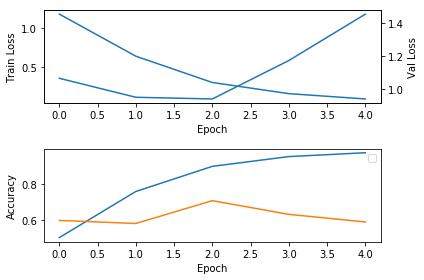

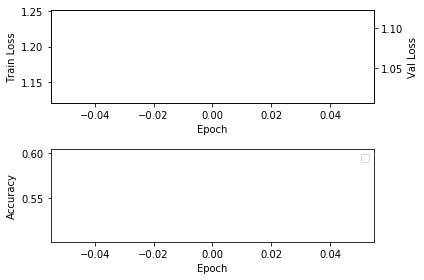

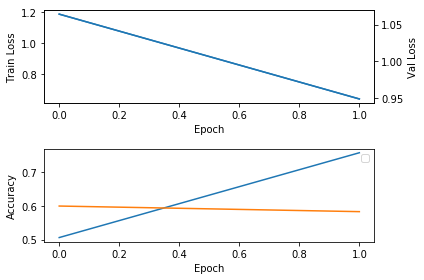

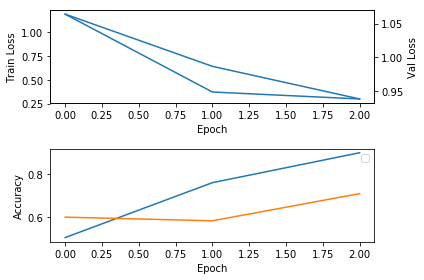

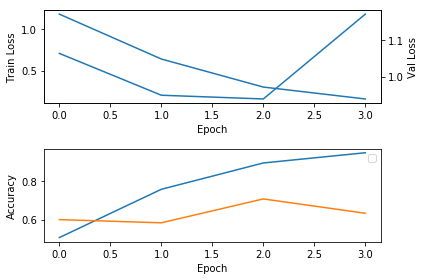

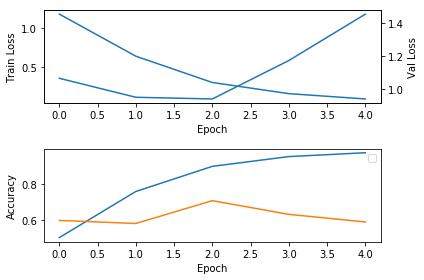

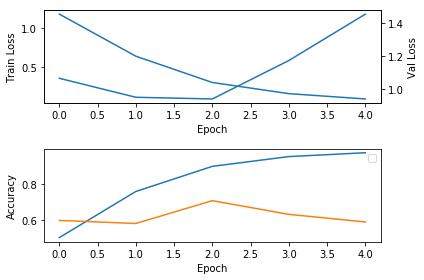

In [30]:
%matplotlib inline

NUM_EPOCHS = 5

train_losses = []
train_accs = []
val_losses = []
val_accs = []

model_checkpointer.set_model(model)
model_checkpointer.on_train_begin()

for epoch in range(NUM_EPOCHS):
    
    model_checkpointer.on_epoch_begin(epoch)
    train_loss, train_acc = train_epoch(model, x_train, y_train)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc = validate_epoch(model, x_val, y_val, class_weights)

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    model_checkpointer.on_epoch_end(epoch, logs={
        "loss": train_loss,
        "val_loss": val_loss
    })
    
    plot_losses(epoch, train_losses, train_accs, val_losses, val_accs)

display.clear_output(wait=True)
plot_losses(epoch, train_losses, train_accs, val_losses, val_accs)    

As we can see, the model starts overfitting after 3 epochs already (more on that later). Let's test how well the best-found fit does on our test set.

## Testing the model

We have held a test-set back in order to verify that the model works on unseen data (and we don't overfit e.g. our hyperparameters to the validation set!).

### Loading the best model

First we should use our checkpointer callback to load the best model. Since it only stores newer models if the validation loss is lower, we can just load the latest model with the known timestamp (assuming they are returned in descending order):

In [31]:
timestamp = "_".join(os.path.basename(model_checkpointer.filepath).split("_")[:2])
best_model_path = [os.path.join(checkpoint_dir, i) for i in os.listdir(checkpoint_dir)
              if os.path.isfile(os.path.join(checkpoint_dir, i))
              and timestamp in i][-1]
model.load_weights(best_model_path)

### Making predictions

Same as with training/validation, run through each batch and create predictions for it.

In [32]:
predictions = []
true_labels = []
sample_weights = []
for x, y in get_shuffled_batches(x_test, y_test):
    prediction = model.predict_on_batch(x)
    predictions.append(prediction)
    true_labels.append(y)
    sample_weights.append(sample_weights_from_class_weights(class_weights, y))

### One-hot to categories

The predictions the model returns are one-hot encoded, so we need to turn them back into categories.

We also need to transform the sample weights to a 1D array for creating the balanced accuracy metric later.

First we wrap them as numpy arrays:

In [33]:
predictions = np.array(predictions)
true_labels = np.array(true_labels)
sample_weights = np.array(sample_weights)

print(predictions.shape)
print(true_labels.shape)
print(sample_weights.shape)

(180, 1, 5)
(180, 1, 5)
(180, 1)


One-hot to categories:

In [34]:
predictions = np.argmax(predictions, axis=2)
true_labels = np.argmax(true_labels, axis=2)

print(predictions.shape)
print(true_labels.shape)

(180, 1)
(180, 1)


Remove the 1D array for 1D batches:

In [35]:
predictions = np.reshape(predictions, predictions.shape[0])
true_labels = np.reshape(true_labels, true_labels.shape[0])
sample_weights = np.reshape(sample_weights, sample_weights.shape[0])

print(predictions.shape)
print(true_labels.shape)
print(sample_weights.shape)

(180,)
(180,)
(180,)


### Calculate metrics

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

metrics = dict(
    precision = precision_score(true_labels, predictions, average=None),
    recall = recall_score(true_labels, predictions, average=None),
    f1 = f1_score(true_labels, predictions, average=None),
    accuracy_raw = accuracy_score(true_labels, predictions),
    accuracy_weighted = accuracy_score(true_labels, predictions, sample_weight=sample_weights),
    confusion = confusion_matrix(true_labels, predictions)
)

metrics

{'precision': array([0.73333333, 0.67924528, 0.3125    , 0.73076923, 0.65517241]),
 'recall': array([0.61111111, 0.75      , 0.20833333, 0.79166667, 0.79166667]),
 'f1': array([0.66666667, 0.71287129, 0.25      , 0.76      , 0.71698113]),
 'accuracy_raw': 0.6666666666666666,
 'accuracy_weighted': 0.6305555555555555,
 'confusion': array([[22,  8,  3,  3,  0],
        [ 6, 36,  2,  3,  1],
        [ 1,  3,  5,  8,  7],
        [ 0,  3,  5, 38,  2],
        [ 1,  3,  1,  0, 19]], dtype=int64)}

### Confusion matrix

I'm pretty sure I copied this code from somewhere ages ago (i.e. the first result on StackOverflow). It just shows the confusion matrix as a heatmap with the relevant prediction results, either raw or normalised.

In [21]:
import itertools
import matplotlib.pylab as plt

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          block=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = np.average(cm)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if block:
        plt.show()

Raw:

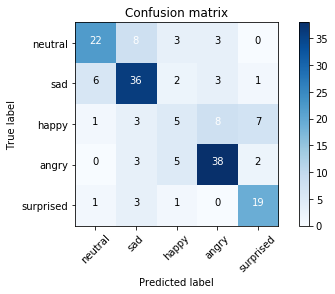

In [38]:
# emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
emotions = ["neutral", "sad", "happy", "angry", "surprised"]

plot_confusion_matrix(metrics["confusion"], classes=emotions)

Normalised:

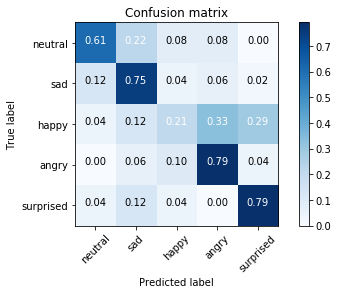

In [39]:
plot_confusion_matrix(metrics["confusion"], classes=emotions, normalize=True)

## Results

The classifier isn't doing a half-bad job! It gets a lot of classes right, but clearly struggles with classifying happiness well. In some runs it gets to 80% accuracy overall, which is pretty decent across 5 classes, although the emotions we are most interested in (happy/sad) are also the least accurate. Previous results with all 8 classes got to about 60% accuracy, which resulted in me combining classes that had a lot of prediction overlap to make the problem a bit easier for the classifier.

## Improvements

The model is overfitting quite quickly so we could look into some regularisation methods. For example, the dataset is only made up of 1441 samples, so scaling that up with data augmentation should be an easy win.

We are currently also training the entire set of layers, which means even the very first few layers are able to specialise to our dataset. We could therefore see if just training e.g. the final few dense layers is sufficient. 

If more regularisation is required we can also look into adding some batch normalisation and/or dropout between our layers. Since we're re-training the entire model anyway, we may as well change it around a bit and see if that improves the results.

Whether Adam is the best choice for online learning is also questionable (based on other models trained in the past), so looking into plain SGD + Nesterov momentum could be an option.

## Combine code for reuse

Before moving on, let's clean up the code a little to make sure we can reuse it more easily going forward

In [22]:
from keras.layers import CuDNNLSTM
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy
from tensorflow import Tensor
from datetime import datetime
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib as mpl
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from IPython import display

class PlotTrainProgress(Callback):
    def __init__(self):
        super().__init__()
        self.train_loss_color = "C0"
        self.val_loss_color = "C1"
        mpl.style.use("seaborn-notebook")
        self.logs = []
        self.fig = None
        self.losses = np.array([])
        self.val_losses = np.array([])
        self.accs = np.array([])
        self.val_accs = np.array([])
        self.x = []
        self.i = 0
        self.ax1 = None
        self.ax2 = None
        self.ax3 = None
        self.ax4 = None

    def _reset(self):
        self.logs = []
        self.fig = None
        self.losses = np.array([])
        self.val_losses = np.array([])
        self.accs = np.array([])
        self.val_accs = np.array([])
        self.x = []
        self.i = 0
        self.ax1 = None
        self.ax2 = None
        self.ax3 = None
        self.ax4 = None

    def on_train_begin(self, logs={}):
        self._reset()

        self.fig = plt.figure()

        self.ax1 = self.fig.add_subplot(211)
        self.ax2 = self.ax1.twinx()
        self.ax3 = self.fig.add_subplot(212)

        self.ax1.tick_params("y", colors=self.train_loss_color)
        self.ax2.tick_params("y", colors=self.val_loss_color)
        self.fig.canvas.draw()

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses = np.append(self.losses, logs.get('loss'))
        self.val_losses = np.append(self.val_losses, logs.get('val_loss'))
        self.accs = np.append(self.accs, logs.get('categorical_accuracy'))
        self.val_accs = np.append(self.val_accs, logs.get('val_categorical_accuracy'))
        self.i += 1

        self.ax1.clear()
        self.ax2.clear()
        self.ax3.clear()

        self.ax1.set_xlabel("Epoch")
        self.ax1.set_ylabel("Train Loss", color=self.train_loss_color)
        self.ax2.set_ylabel("Val Loss", color=self.val_loss_color)
        self.ax1.plot(self.x, self.losses, color=self.train_loss_color)
        self.ax2.plot(self.x, self.val_losses, color=self.val_loss_color)

        self.ax3.set_xlabel("Epoch")
        self.ax3.set_ylabel("Accuracy")
        self.ax3.plot(self.x, self.accs, color=self.train_loss_color, label="Train Accuracy")
        self.ax3.plot(self.x, self.val_accs, color=self.val_loss_color, label="Val Accuracy")
        self.ax3.legend()

        self.fig.tight_layout()
        self.fig.canvas.draw()
        
        display.clear_output(wait=True)
        display.display(self.fig)

#     def on_train_end(self, logs=None):
#         display.clear_output(wait=True)
#         display.display(self.fig)
#         plt.ioff()
#         plt.show()

def pretrained_vgg_with_custom_head():
    model = get_vggish_keras_timedistributed()
    model.load_weights('../pretrained_models/vgg_model.h5')
    x = CuDNNLSTM(127)(model.layers[-1].output)
    x = Dense(NUM_CLASSES, activation='softmax', name='out')(x)
    model = Model(inputs=model.input, outputs=[x])
    optimizer = Adam(lr=vggish_params.LEARNING_RATE, epsilon=vggish_params.ADAM_EPSILON)
    metrics = [categorical_accuracy]
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
    return model

def get_model_checkpointer(checkpoint_dir = "../model_checkpoints/"):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S')
    model_checkpoint_filepath = checkpoint_dir + timestamp + "_epoch-{epoch:02d}_val-{val_loss:.4f}.hdf5"
    model_checkpointer = ModelCheckpoint(model_checkpoint_filepath,
                                         monitor='val_loss',
                                         verbose=0,
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='auto',
                                         period=1)
    return model_checkpointer
    
def load_best_weights(model, model_checkpointer, checkpoint_dir = "../model_checkpoints/"):
    timestamp = "_".join(os.path.basename(model_checkpointer.filepath).split("_")[:2])
    best_model_path = [os.path.join(checkpoint_dir, i) for i in os.listdir(checkpoint_dir)
              if os.path.isfile(os.path.join(checkpoint_dir, i))
              and timestamp in i][-1]
    model.load_weights(best_model_path)
    return model

def train(model, x_train, y_train, x_val, y_val, class_weights, callbacks = None, num_epochs = 5):
    
    callbacks = [] if callbacks is None else callbacks
    
    for callback in callbacks:
        callback.set_model(model)
        callback.on_train_begin()
    
    for epoch in range(num_epochs):
        
        for callback in callbacks:
            callback.on_epoch_begin(epoch)
        
        train_loss, train_acc = train_epoch(model, x_train, y_train)
        val_loss, val_acc = validate_epoch(model, x_val, y_val, class_weights)

        for callback in callbacks:
            callback.on_epoch_end(epoch, logs={
                "loss": train_loss,
                "val_loss": val_loss,
                "categorical_accuracy": train_acc,
                "val_categorical_accuracy": val_acc
            })

    for callback in callbacks:
        callback.on_train_end()
    
    for callback in callbacks:
        if isinstance(callback, ModelCheckpoint):
            model = load_best_weights(model, callback)
            break
    return model

def test(model, x_test, y_test, class_weights):
    predictions = []
    true_labels = []
    sample_weights = []
    for x, y in get_shuffled_batches(x_test, y_test):
        prediction = model.predict_on_batch(x)
        predictions.append(prediction)
        true_labels.append(y)
        sample_weights.append(sample_weights_from_class_weights(class_weights, y))
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    sample_weights = np.array(sample_weights)
    predictions = np.argmax(predictions, axis=2)
    true_labels = np.argmax(true_labels, axis=2)
    predictions = np.reshape(predictions, predictions.shape[0])
    true_labels = np.reshape(true_labels, true_labels.shape[0])
    sample_weights = np.reshape(sample_weights, sample_weights.shape[0])
    
    return dict(
        precision = precision_score(true_labels, predictions, average=None),
        recall = recall_score(true_labels, predictions, average=None),
        f1 = f1_score(true_labels, predictions, average=None),
        accuracy_raw = accuracy_score(true_labels, predictions),
        accuracy_weighted = accuracy_score(true_labels, predictions, sample_weight=sample_weights),
        confusion = confusion_matrix(true_labels, predictions)
    )

## Freezing layers

The model quickly overfits to our dataset. We can reduce this by only training the last few layers.

In [92]:
model = get_vggish_keras_timedistributed(dropout_between_dense = 0.5)
model.load_weights('../pretrained_models/vgg_model.h5')
x = CuDNNLSTM(127)(model.layers[-1].output)
x = Dense(NUM_CLASSES, activation='softmax', name='out')(x)
model = Model(inputs=model.input, outputs=[x])

for layer in model.layers[:-5]:
    layer.trainable = False

optimizer = Adam(lr=vggish_params.LEARNING_RATE, epsilon=vggish_params.ADAM_EPSILON)
metrics = [categorical_accuracy]
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, None, 96, 64, 1)   0         
_________________________________________________________________
conv1 (TimeDistributed)      (None, None, 96, 64, 64)  640       
_________________________________________________________________
pool1 (TimeDistributed)      (None, None, 48, 32, 64)  0         
_________________________________________________________________
time_distributed_41 (TimeDis (None, None, 48, 32, 128) 73856     
_________________________________________________________________
pool2 (TimeDistributed)      (None, None, 24, 16, 128) 0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, None, 24, 16, 256) 295168    
_________________________________________________________________
time_distributed_43 (TimeDis (None, None, 24, 16, 256) 590080    
__________

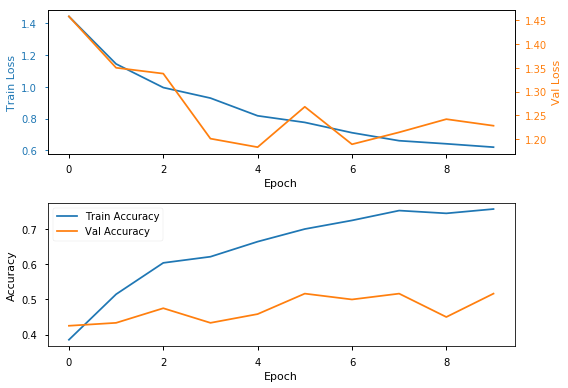

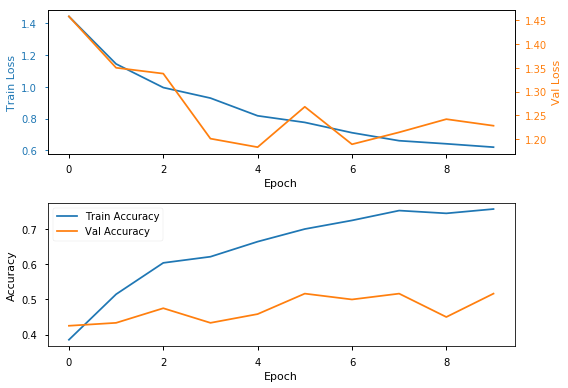

In [93]:
%matplotlib inline

callbacks = [
    get_model_checkpointer(),
    PlotTrainProgress()
]

model = train(model = model, x_train = x_train, y_train = y_train,
              x_val = x_val, y_val = y_val, class_weights = class_weights, callbacks = callbacks, num_epochs = 10)
results = test(model = model, x_test = x_test, y_test = y_test, class_weights = class_weights)

In [94]:
results

{'precision': array([0.50980392, 0.78571429, 0.34615385, 0.86956522, 0.53846154]),
 'recall': array([0.72222222, 0.45833333, 0.75      , 0.41666667, 0.58333333]),
 'f1': array([0.59770115, 0.57894737, 0.47368421, 0.56338028, 0.56      ]),
 'accuracy_raw': 0.5555555555555556,
 'accuracy_weighted': 0.5861111111111111,
 'confusion': array([[26,  2,  6,  1,  1],
        [13, 22, 12,  0,  1],
        [ 4,  1, 18,  1,  0],
        [ 8,  2,  8, 20, 10],
        [ 0,  1,  8,  1, 14]], dtype=int64)}

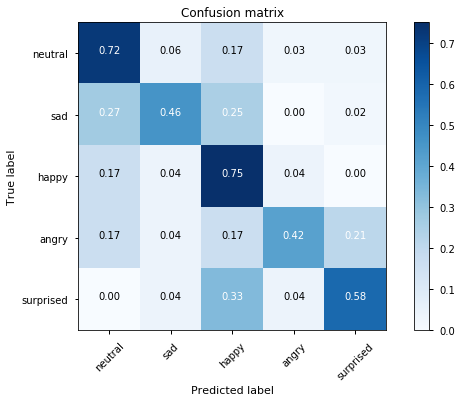

In [95]:
plot_confusion_matrix(results["confusion"], classes=emotions, normalize=True)

### Unlocking more layers with a lower learning rate

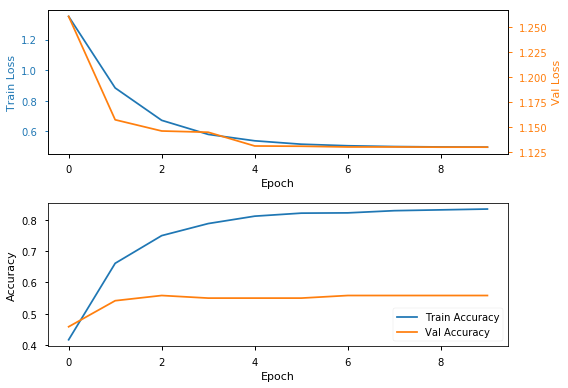

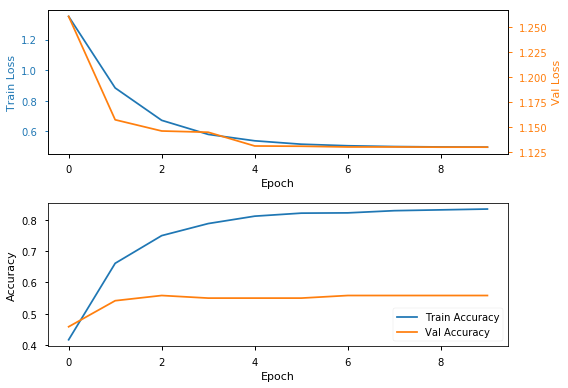

In [45]:
import math
import keras.backend as K

model = get_vggish_keras_timedistributed(dropout_between_dense = 0)
model.load_weights('../pretrained_models/vgg_model.h5')
x = CuDNNLSTM(127)(model.layers[-1].output)
x = Dense(NUM_CLASSES, activation='softmax', name='out')(x)
model = Model(inputs=model.input, outputs=[x])

for layer in model.layers[:-5]:
    layer.trainable = False

optimizer = Adam(lr=vggish_params.LEARNING_RATE, epsilon=vggish_params.ADAM_EPSILON)
metrics = [categorical_accuracy]
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

callbacks = [
    get_model_checkpointer(),
    PlotTrainProgress()
]
    
callbacks = [] if callbacks is None else callbacks

for callback in callbacks:
    callback.set_model(model)
    callback.on_train_begin()

for epoch in range(10):

    for callback in callbacks:
        callback.on_epoch_begin(epoch)

    train_loss, train_acc = train_epoch(model, x_train, y_train)
    val_loss, val_acc = validate_epoch(model, x_val, y_val, class_weights)

    for callback in callbacks:
        callback.on_epoch_end(epoch, logs={
            "loss": train_loss,
            "val_loss": val_loss,
            "categorical_accuracy": train_acc,
            "val_categorical_accuracy": val_acc
        })
        
#     if epoch == 2:
#         for layer in model.layers[-7:]:
#             layer.trainable = True
#         optimizer = Adam(lr=eval(model.optimizer.lr) / 2, epsilon=vggish_params.ADAM_EPSILON)
#         model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
        
    K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr) / 2)
    
#     if epoch == 4:

# #         for layer in model.layers:
# #             layer.trainable = True

#         optimizer = Adam(lr=eval(model.optimizer.lr) / 10, epsilon=vggish_params.ADAM_EPSILON)
#         model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
        
#     if epoch == 3:

#         optimizer = Adam(lr=eval(model.optimizer.lr) / 10, epsilon=vggish_params.ADAM_EPSILON)
#         model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
    
for callback in callbacks:
    callback.on_train_end()

for callback in callbacks:
    if isinstance(callback, ModelCheckpoint):
        model = load_best_weights(model, callback)
        break


results = test(model = model, x_test = x_test, y_test = y_test, class_weights = class_weights)

In [46]:
results

{'precision': array([0.62745098, 0.7027027 , 0.47619048, 0.7755102 , 0.63636364]),
 'recall': array([0.88888889, 0.54166667, 0.41666667, 0.79166667, 0.58333333]),
 'f1': array([0.73563218, 0.61176471, 0.44444444, 0.78350515, 0.60869565]),
 'accuracy_raw': 0.6666666666666666,
 'accuracy_weighted': 0.6444444444444445,
 'confusion': array([[32,  4,  0,  0,  0],
        [13, 26,  2,  2,  5],
        [ 4,  5, 10,  5,  0],
        [ 2,  1,  4, 38,  3],
        [ 0,  1,  5,  4, 14]], dtype=int64)}

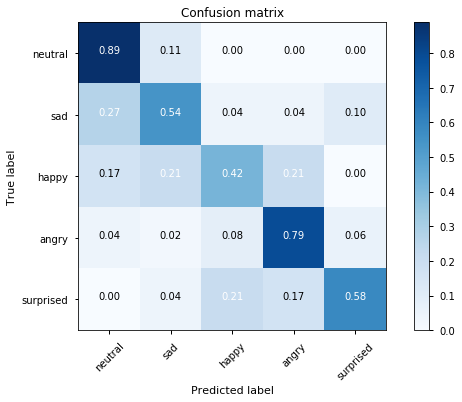

In [47]:
emotions = ["neutral", "sad", "happy", "angry", "surprised"]
plot_confusion_matrix(results["confusion"], classes=emotions, normalize=True)

In [48]:
import keras.backend as K
K.clear_session()

## Data Augmentation

To be continued...

// last update: w/c 2018-11-19, should get this chapter out next week :)

In [25]:
from pydub import AudioSegment
from pydub.playback import play

def read_audiosegment(file_path):
    return AudioSegment.from_file(file_path, format="wav")

audio = read_audiosegment(str(wav_files[0]))
audio_datatype = np.array(audio.get_array_of_samples()).dtype

assert audio_datatype == np.int16
play(audio)

C:\Users\Sam\Anaconda3\envs\vggec\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
C:\Users\Sam\Anaconda3\envs\vggec\lib\site-packages\pydub\utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


In [26]:
def normalise_volume(audio_segment):
    return audio_segment.apply_gain(-audio_segment.max_dBFS)

print("Max amplitude pre normalisation: ", max(audio.get_array_of_samples()))
audio = normalise_volume(audio)

print("Max amplitude post normalisation", max(audio.get_array_of_samples()))
play(audio)

Max amplitude pre normalisation:  1330
Max amplitude post normalisation 32767


In [27]:
def detect_leading_silence(audio_segment, silence_threshold=-50.0, chunk_size=10):
    trim_ms = 0  # ms
    for pos in range(0, len(audio_segment), chunk_size):
        seq = audio_segment[pos:pos + chunk_size]
        if seq.dBFS < silence_threshold:
            trim_ms += chunk_size
        else:
            break
    return trim_ms

def trim_silence(audio_segment):
    trim_start = detect_leading_silence(audio_segment)
    trim_end_length = detect_leading_silence(audio_segment.reverse())
    trim_end = len(audio_segment) - trim_end_length
    return audio_segment[trim_start:trim_end]

print("Audio length before trimming: ", len(audio))
audio = trim_silence(audio)
print("Audio length after trimming: ", len(audio))
play(audio)

Audio length before trimming:  3303
Audio length after trimming:  1523


In [28]:
# taken from: https://stackoverflow.com/questions/43408833/how-to-increase-decrease-playback-speed-on-wav-file

def change_speed(audio_segment, speed=1.0):
    # Manually override the frame_rate. This tells the computer how many
    # samples to play per second
    altered_frame_rate = audio_segment._spawn(
        audio_segment.raw_data,
        overrides={
            "frame_rate": int(audio_segment.frame_rate * speed)
        }
    )

    # convert the sound with altered frame rate to a standard frame rate
    # so that regular playback programs will work right. They often only
    # know how to play audio at standard frame rate (like 44.1k)
    return altered_frame_rate.set_frame_rate(audio_segment.frame_rate)

print("Audio length before changing speed: ", len(audio))
audio = change_speed(audio, speed=1.1)
print("Audio length sped up by 10%: ", len(audio))
play(audio)

Audio length before changing speed:  1523
Audio length sped up by 10%:  1385


In [29]:
from pydub.generators import WhiteNoise

def add_noise(audio_segment, noise_db):
    noise = WhiteNoise(sample_rate=audio_segment.frame_rate)
    noise_seg = noise.to_audio_segment(len(audio_segment), volume=noise_db)
    return audio_segment.overlay(noise_seg)

audio = add_noise(audio, -30)
play(audio)

In [30]:
from vggish_input import waveform_to_examples 

def audiosegment_to_samples(audio_segment):
    raw_data = np.array(audio_segment.get_array_of_samples())
    raw_data = raw_data / 32768.0 # convert to range [-1, 1]
    return waveform_to_examples(raw_data, audio_segment.frame_rate)
    
input_data = audiosegment_to_samples(audio)
print(input_data.shape)

(1, 96, 64)


In [31]:
def generate_augmentations(audio_segment):
    for speed in [0.8, 0.9, 1.1, 1.2]:
        yield change_speed(audio_segment, speed)
    for noise_db in [-30, -40]:
        yield add_noise(audio_segment, noise_db)

In [32]:
def wav_files_in_path(path):
    data_path = Path(path)
    wav_files = data_path.glob("*.wav")
    for f in wav_files:
        yield f.name, str(f)

In [33]:
wav_files[0]

WindowsPath('../data/03-01-01-01-01-01-01.wav')

In [34]:
import types

class Step:
    def __init__(self, func, creates_key=False):
            self.func = func
            self.creates_key = creates_key
                        
    def run(self, in_gen):
        for elem in in_gen:
            
            if not self.creates_key:
                key, elem = elem

            output = self.func(elem)
            
            if isinstance(output, types.GeneratorType):
                for output_elem in output:
                    if self.creates_key:
                        yield output_elem
                    else:
                        yield key, output_elem
            else:
                if self.creates_key:
                    yield output
                else:
                    yield key, output

pipeline = [
    read_audiosegment,
    normalise_volume,
    trim_silence,
    generate_augmentations,
    audiosegment_to_samples
]
    
input_step = Step(wav_files_in_path, creates_key=True)
compiled_pipeline = input_step.run(["../data"])
for func in pipeline:
    step = Step(func)
    compiled_pipeline = step.run(compiled_pipeline)

In [35]:
from collections import defaultdict

data = defaultdict(list)        
for key, output in compiled_pipeline:
    data[key].append(output)

In [36]:
import itertools

x_train, y_train = zip(*[(data[key], [value["class"]] * len(data[key])) for key, value in labels.items() if value["speaker"] in train_speakers])
x_val, y_val = zip(*[(data[key], [value["class"]] * len(data[key])) for key, value in labels.items() if value["speaker"] in val_speakers])
x_test, y_test = zip(*[(data[key], [value["class"]] * len(data[key])) for key, value in labels.items() if value["speaker"] in test_speakers])

x_train = list(itertools.chain.from_iterable(x_train))
x_val = list(itertools.chain.from_iterable(x_val))
x_test = list(itertools.chain.from_iterable(x_test))

y_train = list(itertools.chain.from_iterable(y_train))
y_val = list(itertools.chain.from_iterable(y_val))
y_test = list(itertools.chain.from_iterable(y_test))

x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

y_train = to_one_hot(y_train, NUM_CLASSES)
y_val = to_one_hot(y_val, NUM_CLASSES)
y_test = to_one_hot(y_test, NUM_CLASSES)

In [37]:
print(f"Training size: {len(x_train)}")
print(f"Validation size: {len(x_val)}")
print(f"Test size: {len(x_test)}")

Training size: 6840
Validation size: 720
Test size: 1080


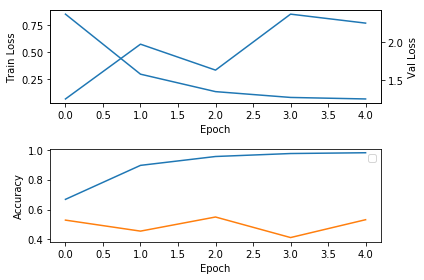

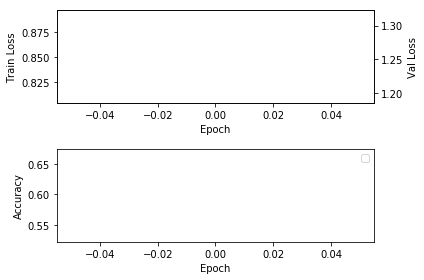

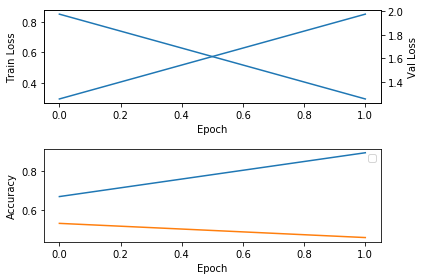

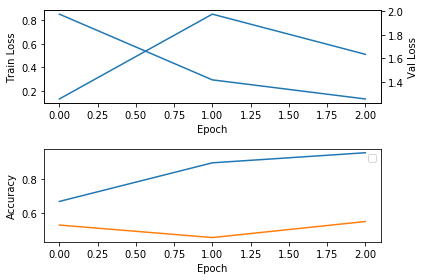

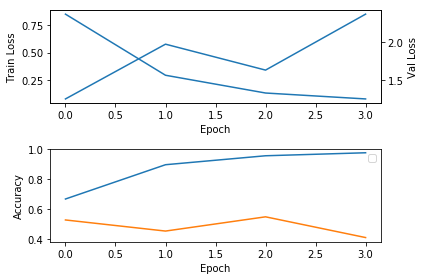

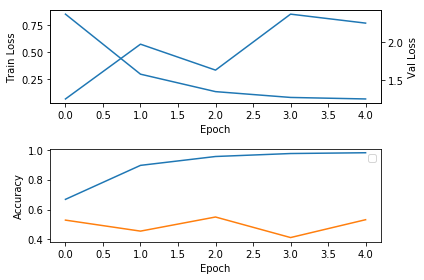

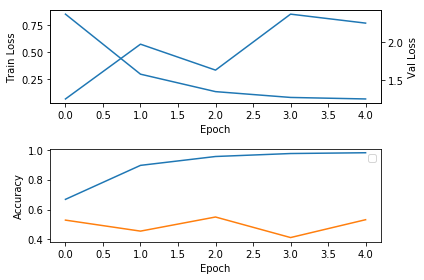

In [38]:
%matplotlib inline

model = pretrained_vgg_with_custom_head()
model = train(model=model, x_train = x_train, y_train = y_train,
              x_val = x_val, y_val = y_val, class_weights = class_weights)
results = test(model=model, x_test = x_test, y_test = y_test, class_weights = class_weights)

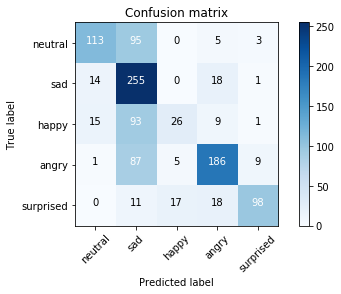

In [41]:
emotions = ["neutral", "sad", "happy", "angry", "surprised"]

plot_confusion_matrix(results["confusion"], classes=emotions)

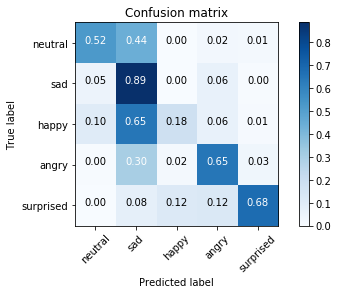

In [42]:
plot_confusion_matrix(results["confusion"], classes=emotions, normalize=True)